# Example: read and write FreeGSNKE data to IMAS IDS
---

This example notebook shows how to read/write FreeGSNKE equilibrium information into the Integrated Modelling & Analysis Suite (IMAS) Interface Data Strucutres (IDS) format. These data structures are intended to provide fusion modellers with a set of standardised data structures (the IDSs) that can be used to link different modelling codes together. 

To do this, we use the [IMAS-python](https://imas-python.readthedocs.io/en/stable/) package (which should be installed with FreeGSNKE, else you can `pip install imas-python[netcdf,xarray]` into your conda envornoment). It is recommended to check out the docs relating to this package and review the basic training manual [here](https://imas-python.readthedocs.io/en/latest/courses/basic_user_training.html). To view the structure of the IMAS data dictionary, i.e. the different types of IDS available, see [here](https://imas-data-dictionary.readthedocs.io/en/latest/).

In this notebook, we will provide a basic overview of how to:
 - **write** the results from a FreeGSNKE equilibrium object (following a solve) to an equilibrium IDS and save to netCDF.
 - **read** data from an equilibrium IDS and extract the required data to begin initialising the 'equilibrium' and 'profiles' objects for use in FreeGSNKE. 

Note: these examples do not make use of the full [IMAS-core](git.iter.org) installation which is not currently open-source.

### Load packages and solve for an equilibrium

In [1]:
# load modules
import numpy as np
import matplotlib.pyplot as plt
import os
import imas
print(imas.__version__)

13:13:06 CRITICAL Could not import 'imas_core': No module named 'imas_core'. Some functionality is not available. @imas_interface.py:34


2.0.1


Active coils --> built from pickle file.
Passive structures --> built from pickle file.
Limiter --> built from pickle file.
Wall --> built from pickle file.
Magnetic probes --> none provided.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.
Forward static solve SUCCESS. Tolerance 9.19e-11 (vs. requested 1.00e-09) reached in 26/100 iterations.


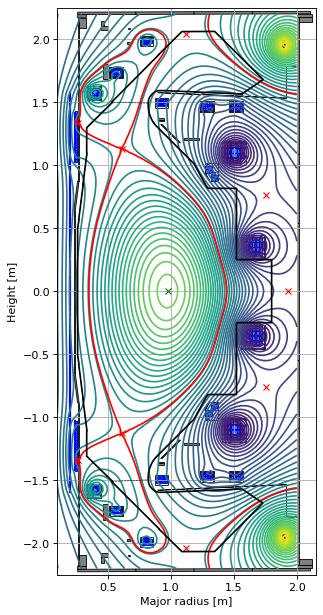

In [2]:
# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak(
    active_coils_path=f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle",
    passive_coils_path=f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle",
    limiter_path=f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle",
    wall_path=f"../machine_configs/MAST-U/MAST-U_like_wall.pickle",
)

# initialise equilibrium object
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

# initialise profile object
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

# initialise solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

# set coil currents
import pickle
with open('data/simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)

for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# carry out forward solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# plot the resulting equilbrium
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

### Write to IDS

Here we pass the the equilibrium object to a function that will initialise the `equilibirum` IDS, extract the relevant quantities (see the structure of the IDS here), and write to netCDF.

In [3]:
from freegsnke import imas_read_write

In [4]:
equilibrium_ids = imas_read_write.write_equilibrium_to_ids(eq)

13:13:12 INFO     Parsing data dictionary version 4.0.0 @dd_zip.py:89


---
IDS being populated...
   high level properties...
   vacuum field properties...
   plasma boundary quantities...
   global quantities...
Dicrepancy between psi_func and plasma_psi detected. psi_func has been re-set.
psinorm contains 0 or 1, which may cause numerical issues druing safety factor calculation.
   coil currents...
   1D profile quantities...
   2D profile quantities...
done.


Now that it has been built, we can inspect the overall structure.

In [5]:
# inspect at high level
imas.util.inspect(equilibrium_ids, hide_empty_nodes=True)

╭────────────────────────── IDS: equilibrium (DD version 4.0.0) ──────────────────────────╮
│ Description of a 2D, axi-symmetric, tokamak equilibrium; result of an equilibrium code. │
│ ╭──────────────────────────────────── Attributes ─────────────────────────────────────╮ │
│ │ has_value = True                                                                    │ │
│ │  metadata = <IDSMetadata for 'equilibrium'>                                         │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────╯ │
│ ╭──────────────────────────────────── Child nodes ────────────────────────────────────╮ │
│ │                  code = <IDSStructure (IDS:equilibrium, code)>                      │ │
│ │        ids_properties = <IDSStructure (IDS:equilibrium, ids_properties)>            │ │
│ │                  time = <IDSNumericArray (IDS:equilibrium, time, FLT_1D)>           │ │
│ │                         numpy.ndarray([0.])                                         │ │
│ │            time_slice = <IDSStructArray (IDS:equilibrium, time_slice with 1 items)> │ │
│ │ vacuum_toroidal_field = <IDSStructure (IDS:equilibrium, vacuum_toroidal_field)>     │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────╯ │
╰─────────────────────────────────────────────────────────────────────────────────────────╯

We can inspect at lower levels of the structure too.

In [6]:
# inspect at a lower level
imas.util.inspect(equilibrium_ids.time_slice[0].global_quantities, hide_empty_nodes=True)

╭──────────────────── IDS structure: time_slice[0]/global_quantities (DD version 4.0.0) ────────────────────╮
│ 0D parameters of the equilibrium                                                                          │
│ ╭───────────────────────────────────────────── Attributes ──────────────────────────────────────────────╮ │
│ │ has_value = True                                                                                      │ │
│ │  metadata = <IDSMetadata for 'global_quantities'>                                                     │ │
│ ╰───────────────────────────────────────────────────────────────────────────────────────────────────────╯ │
│ ╭───────────────────────────────────────────── Child nodes ─────────────────────────────────────────────╮ │
│ │           area = <IDSFloat0D (IDS:equilibrium, time_slice[0]/global_quantities/area, FLT_0D)>         │ │
│ │                  float(1.7180780745992603)                                                            │ │
│ │       beta_pol = <IDSFloat0D (IDS:equilibrium, time_slice[0]/global_quantities/beta_pol, FLT_0D)>     │ │
│ │                  float(2.786690005880825)                                                             │ │
│ │       beta_tor = <IDSFloat0D (IDS:equilibrium, time_slice[0]/global_quantities/beta_tor, FLT_0D)>     │ │
│ │                  float(0.2763218099984661)                                                            │ │
│ │ current_centre = <IDSStructure (IDS:equilibrium, time_slice[0]/global_quantities/current_centre)>     │ │
│ │             ip = <IDSFloat0D (IDS:equilibrium, time_slice[0]/global_quantities/ip, FLT_0D)>           │ │
│ │                  float(620000.0)                                                                      │ │
│ │     length_pol = <IDSFloat0D (IDS:equilibrium, time_slice[0]/global_quantities/length_pol, FLT_0D)>   │ │
│ │                  float(5.286075299082873)                                                             │ │
│ │           li_3 = <IDSFloat0D (IDS:equilibrium, time_slice[0]/global_quantities/li_3, FLT_0D)>         │ │
│ │                  float(0.7154625581879284)                                                            │ │
│ │  magnetic_axis = <IDSStructure (IDS:equilibrium, time_slice[0]/global_quantities/magnetic_axis)>      │ │
│ │       psi_axis = <IDSFloat0D (IDS:equilibrium, time_slice[0]/global_quantities/psi_axis, FLT_0D)>     │ │
│ │                  float(0.6140391904777606)                                                            │ │
│ │   psi_boundary = <IDSFloat0D (IDS:equilibrium, time_slice[0]/global_quantities/psi_boundary, FLT_0D)> │ │
│ │                  float(0.1899256484822329)                                                            │ │
│ │           q_95 = <IDSFloat0D (IDS:equilibrium, time_slice[0]/global_quantities/q_95, FLT_0D)>         │ │
│ │                  float(6.952771138824017)                                                             │ │
│ │         q_axis = <IDSFloat0D (IDS:equilibrium, time_slice[0]/global_quantities/q_axis, FLT_0D)>       │ │
│ │                  float(2.1139055031926173)                                                            │ │
│ │          q_min = <IDSStructure (IDS:equilibrium, time_slice[0]/global_quantities/q_min)>              │ │
│ │         volume = <IDSFloat0D (IDS:equilibrium, time_slice[0]/global_quantities/volume, FLT_0D)>       │ │
│ │                  float(9.221585091940714)                                                             │ │
│ ╰───────────────────────────────────────────────────────────────────────────────────────────────────────╯ │
╰───────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [7]:
# inspect at a lower level
imas.util.inspect(equilibrium_ids.time_slice[0].constraints, hide_empty_nodes=True)

╭────────────────────────── IDS structure: time_slice[0]/constraints (DD version 4.0.0) ──────────────────────────╮
│ In case of equilibrium reconstruction under constraints, measurements used to constrain the equilibrium,        │
│ reconstructed values and accuracy of the fit. The names of the child nodes correspond to the following          │
│ definition: the solver aims at minimizing a cost function defined as : J=1/2*sum_i [ weight_i^2                 │
│ (reconstructed_i - measured_i)^2 / sigma_i^2 ]. in which sigma_i is the standard deviation of the measurement   │
│ error (to be found in the IDS of the measurement)                                                               │
│ ╭──────────────────────────────────────────────── Attributes ─────────────────────────────────────────────────╮ │
│ │ has_value = True                                                                                            │ │
│ │  metadata = <IDSMetadata for 'constraints'>                                                                 │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────╯ │
│ ╭──────────────────────────────────────────────── Child nodes ────────────────────────────────────────────────╮ │
│ │         pf_current = <IDSStructArray (IDS:equilibrium, time_slice[0]/constraints/pf_current with 12 items)> │ │
│ │ pf_passive_current = <IDSStructArray (IDS:equilibrium, time_slice[0]/constraints/pf_passive_current with    │ │
│ │                      138 items)>                                                                            │ │
│ │       strike_point = <IDSStructArray (IDS:equilibrium, time_slice[0]/constraints/strike_point with 8        │ │
│ │                      items)>                                                                                │ │
│ │            x_point = <IDSStructArray (IDS:equilibrium, time_slice[0]/constraints/x_point with 9 items)>     │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────╯ │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

We can also print the entire data structure tree, however, this can be quite large if there is a lot of data. 

In [8]:
# to print the full data structure tree
# imas.util.print_tree(equilibrium_ids, hide_empty_nodes=True)

If unsure of where exactly a quantity is located in the structure, you can search for certain strings. Note that this function will return all possible locations, without revealing if that location is empty.

In [9]:
imas.util.find_paths(equilibrium_ids, "psi_boundary")

['time_slice/global_quantities/psi_boundary',
 'time_slice/global_quantities/psi_boundary_error_upper',
 'time_slice/global_quantities/psi_boundary_error_lower']

If there are entries in the current IDS that have not been filled, you can add the data manually.

See the https://imas-data-dictionary.readthedocs.io/en/latest/generated/ids/equilibrium.html for the data dictionary structure.

In [10]:
# for example, suppose we want to rename the IDS
equilibrium_ids.ids_properties.name = "Test Equilibrium #18"

# perhaps we want to change the shot/simulation time (at which the equilibrium may have been calculated)
equilibrium_ids.time[0] = 2.3 # seconds

Now we can write the data to a netCDF file as follows. See [here](https://imas-python.readthedocs.io/en/stable/netcdf.html) for more details.

In [11]:
# # save IDS to netcdf
# dbentry = imas.DBEntry(name,"w")
# dbentry.put(equilibrium_ids)

### Read from an IDS

Now we can read the equilibrium IDS we just saved using the following:

In [12]:
# # load IDS back from netcdf
# loaded_dbentry = imas.DBEntry(name,"r")
# equilibrium_ids = loaded_dbentry.get("equilibrium")  

# # inspect
# imas.util.inspect(equilibrium_ids, hide_empty_nodes=True)

Supposing we now have the equilibrium information, we can use/manipulate it however we like. However, if we want to load it into FreeGSNKE there are a few different considerations.

Here, we are assuming (and know) that the same machine description used to create the data will be used when loading it. This makes it easier to extract the coil currents into the tokamak object and therefore load the equilibrium. This means when sharing equilibrium IDS, the corresponding tokamak machine description files need to be shared too. 

If this is not the case and we don't know which machine was used to generate the data, then we need to look 

At some point in the future, we

1. W

In [13]:
time_slice = equilibrium_ids.time_slice[0]

In [14]:
n = 2**np.array([6,7,8,9,10,11]) + 1          # array of possible grid sizes
nx = n[n >= len(time_slice.profiles_2d[0].grid.dim1)][0]
ny = n[n >= len(time_slice.profiles_2d[0].grid.dim2)][0]

# need to ensure the grid encompasses the limiter geometry
Rmin = min(np.min(time_slice.profiles_2d[0].grid.dim1), min(tokamak.limiter.R))
Rmax = max(np.max(time_slice.profiles_2d[0].grid.dim1), max(tokamak.limiter.R))
Zmin = min(np.min(time_slice.profiles_2d[0].grid.dim2), min(tokamak.limiter.Z))
Zmax = max(np.max(time_slice.profiles_2d[0].grid.dim2), max(tokamak.limiter.Z))

In [15]:
eq_new = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=Rmin, Rmax=Rmax,   # radial range
    Zmin=Zmin, Zmax=Zmax,   # vertical range
    nx=nx,                  # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=ny,                  # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
)  

In [16]:
# sets the plasma flux using the data
# eq_new._updatePlasmaPsi(plasma_psi=time_slice.profiles_2d[1].psi)


In [17]:
Ip = np.abs(time_slice.global_quantities.ip)      # this might be negative
fvac = equilibrium_ids.vacuum_toroidal_field.b0[0] * equilibrium_ids.vacuum_toroidal_field.r0

# need to fit the p' and FF' profiles
psi_n = time_slice.profiles_1d.psi_norm
pprime_data = time_slice.profiles_1d.dpressure_dpsi
ffprime_data = time_slice.profiles_1d.f_df_dpsi
p_data = time_slice.profiles_1d.pressure
f_data = time_slice.profiles_1d.f

# extract flux map
R,Z = np.meshgrid(time_slice.profiles_2d[0].grid.dim1,time_slice.profiles_2d[0].grid.dim2, indexing='ij')
psi = time_slice.profiles_2d[0].psi / (2*np.pi)


In [18]:
from freegsnke import jtor_update

profiles_new = jtor_update.GeneralPprimeFFprime(
    eq=eq_new,                            # equilibrium object
    Ip=Ip,                            # total plasma current
    fvac=fvac,                        # f vacuum parameter (R*Bt)
    psi_n=psi_n,
    pprime_data=pprime_data,
    ffprime_data=ffprime_data,
    p_data=p_data,
    f_data=f_data,
    )

In [19]:
# initialise solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq_new)    

In [20]:
# constraints for inverse solver
from freegsnke.inverse import Inverse_optimizer
constrain = Inverse_optimizer(psi_vals=np.stack([R, Z, psi], axis=-1))

In [21]:
currents = eq.tokamak.getCurrentsVec()

In [22]:
GSStaticSolver.solve(eq=eq_new, 
                     profiles=profiles_new, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     verbose=True, # print output
                     l2_reg=1e-16
                     )

-----
Inverse static solve starting...


/Users/kpentlan/Documents/Projects/Software/freegs4e/freegs4e/gradshafranov.py:431: RuntimeWarning: invalid value encountered in sqrt
  * sqrt(R * Rc)


Initial guess for plasma_psi successful, residual found.
Initial relative error = 9.65e-01
-----
Iteration: 0
Using simplified Green's Jacobian (of constraints wrt coil currents) to optimise the currents.
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update triggered!
Resizing of the control current update trigge

This equilibrium has not been solved: the separatrix can not be drawn.
Please solve first for a plot of the critical points.


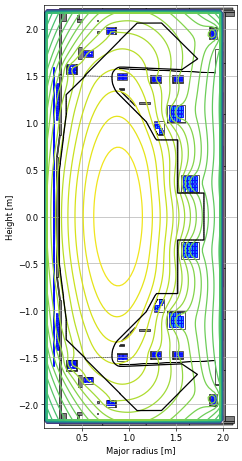

In [ ]:
# plot the resulting equilbrium
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=60)
ax1.grid(True, which='both')
eq_new.plot(axis=ax1, show=False)
eq_new.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

In [ ]:
for i, key in enumerate(eq_new.tokamak.coil_names[0:12]):
    eq.tokamak.set_coil_current(coil_label=key, current_value=time_slice.constraints.pf_current[i].measured)

In [ ]:
# carry out forward solve
# eq_new._updatePlasmaPsi(plasma_psi=time_slice.profiles_2d[1].psi)

GSStaticSolver.solve(eq=eq_new, 
                     profiles=profiles_new, 
                     constrain=None, 
                     target_relative_tolerance=1e-9,
                     verbose=True)


-----
Forward static solve starting...
Initial guess for plasma_psi successful, residual found.
Initial relative error = 9.65e-01
-----
Picard iteration: 0
Update too large, resized.
...relative error =  9.45e-01
-----
Picard iteration: 1
Update too large, resized.
...relative error =  9.22e-01
-----
Picard iteration: 2
Update too large, resized.
...relative error =  8.96e-01
-----
Picard iteration: 3
Update too large, resized.
...relative error =  8.65e-01
-----
Picard iteration: 4
Update too large, resized.
...relative error =  8.29e-01
-----
Picard iteration: 5
Update too large, resized.
...relative error =  7.87e-01
-----
Picard iteration: 6
Update too large, resized.
...relative error =  7.40e-01
-----
Picard iteration: 7
Update too large, resized.
...relative error =  6.88e-01
-----
Picard iteration: 8
Update too large, resized.
...relative error =  6.27e-01
-----
Picard iteration: 9
Update too large, resized.
...relative error =  5.55e-01
-----
Picard iteration: 10
Update too la

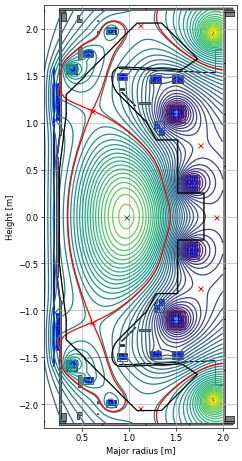

In [ ]:

# plot the resulting equilbrium
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=60)
ax1.grid(True, which='both')
eq_new.plot(axis=ax1, show=False)
eq_new.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()